# 通用数据加载与增强

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/dataset/mindspore_augment_common_data.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/dataset/mindspore_augment_common_data.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/advanced/dataset/augment_common_data.ipynb)

在处理图像、文本和音频等不同类别的数据时，需要使用到一些通用的数据处理和增强操作。

MindSpore提供了`transforms`模块用于执行通用数据增强操作。

以下章节将以CIFAR-10数据集和MNIST数据集作为例子，简要介绍一些通用数据增强操作的使用示例。更多详细信息，请参见API文档[mindspore.dataset.transforms](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html)。

## 加载图像数据

1. 以下示例代码分别将CIFAR-10数据集和MNIST数据集下载并解压到指定位置，网络状况良好的情况下此段代码预计需执行三至五分钟。

In [1]:
import os
from mindvision.dataset import DownLoad

dl_path_cifar10 = "./datasets"
dl_url_cifar10 = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

dl = DownLoad()

# 下载CIFAR-10数据集并解压
dl.download_and_extract_archive(url=dl_url_cifar10, download_path=dl_path_cifar10)

# MNIST数据集保存路径
dl_path_mnist = "./mnist"
dl_url_mnist_labels = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
dl_url_mnist_images = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"

# 下载MNIST数据集并解压
dl.download_and_extract_archive(url=dl_url_mnist_labels, download_path=dl_path_mnist)
dl.download_and_extract_archive(url=dl_url_mnist_images, download_path=dl_path_mnist)

image_gz = "./mnist/train-images-idx3-ubyte.gz"
label_gz = "./mnist/train-labels-idx1-ubyte.gz"

# 删除压缩文件
if os.path.exists(image_gz):
    os.remove(image_gz)
if os.path.exists(label_gz):
    os.remove(label_gz)

2. 使用[mindspore.dataset.Cifar10Dataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html#mindspore.dataset.Cifar10Dataset)接口加载CIFAR-10数据集，使用[mindspore.dataset.MnistDataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset)接口加载MNIST数据集。示例代码如下：

CIFAR-10  shape: (32, 32, 3) label: 9
CIFAR-10  shape: (32, 32, 3) label: 2
CIFAR-10  shape: (32, 32, 3) label: 0
CIFAR-10  shape: (32, 32, 3) label: 8
MNIST  shape: (28, 28, 1) label: 7
MNIST  shape: (28, 28, 1) label: 2
MNIST  shape: (28, 28, 1) label: 4
MNIST  shape: (28, 28, 1) label: 4


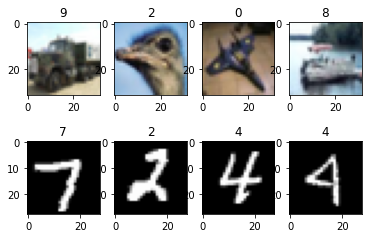

In [2]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
%matplotlib inline

DATA_DIR_MNIST = "./mnist/"
DATA_DIR_CIFAR10 = "./datasets/cifar-10-batches-bin/"

ds.config.set_seed(1)

# 加载数据集，选取4张图片
dataset_cifar10 = ds.Cifar10Dataset(DATA_DIR_CIFAR10, num_samples=4)
dataset_mnist = ds.MnistDataset(DATA_DIR_MNIST, num_samples=4)

def printDataset(dataset_list, name_list):
    """显示数据集"""
    dataset_sizes = []
    for dataset in dataset_list:
        dataset_sizes.append(dataset.get_dataset_size())
    row = len(dataset_list)      # 画布行数
    column = max(dataset_sizes)  # 画布列数
    pos = 1
    for i in range(row):
        for data in dataset_list[i].create_dict_iterator(output_numpy=True):
            plt.subplot(row, column, pos)                          # 显示位置
            plt.imshow(data['image'].squeeze(), cmap=plt.cm.gray)  # 显示内容
            plt.title(data['label'])                               # 显示标题
            print(name_list[i], " shape:", data['image'].shape, "label:", data['label'])
            pos = pos + 1
        pos = column * (i + 1) + 1

printDataset([dataset_cifar10, dataset_mnist], ["CIFAR-10", "MNIST"])

## mindspore.dataset.transforms模块

`transforms`模块支持一系列通用数据增强操作。其中部分操作使用C++实现以获得更好的性能；另一些操作使用Python实现，如基于NumPy实现。

### Compose

`Compose`接收一个数据增强操作序列，然后将其组合成单个数据增强操作。

下面的样例首先加载[CIFAR-10数据集[1]](#参考文献)，然后同时定义解码、缩放和数据类型转换操作，并作用于已加载的图片，最后输出处理后的图片形状及对应标签，并对图片进行展示。

Transformed image Shape: (3, 200, 200) , Transformed label: 4
Transformed image Shape: (3, 200, 200) , Transformed label: 9
Transformed image Shape: (3, 200, 200) , Transformed label: 6
Transformed image Shape: (3, 200, 200) , Transformed label: 5
Transformed image Shape: (3, 200, 200) , Transformed label: 7


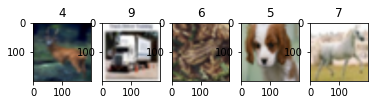

In [7]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore.dataset.transforms import Compose
from PIL import Image
%matplotlib inline

ds.config.set_seed(8)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 加载CIFAR-10数据集，选取5张图片
dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=5, shuffle=True)

def decode(image):
    """定义解码函数"""
    return Image.fromarray(image)

# 定义transforms列表
transforms_list = [
    decode,
    vision.Resize(size=(200, 200)),
    vision.ToTensor()
]

# 通过Compose操作将transforms列表中函数作用于数据集图片
compose_trans = Compose(transforms_list)
dataset2 = dataset1.map(operations=compose_trans, input_columns=["image"])

# 打印数据增强操作后图片的形状、标签
image_list, label_list = [], []
for data in dataset2.create_dict_iterator():
    image_list.append(data['image'])
    label_list.append(data['label'])
    print("Transformed image Shape:", data['image'].shape, ", Transformed label:", data['label'])

num_samples = len(image_list)
for i in range(num_samples):
    plt.subplot(1, len(image_list), i + 1)
    plt.imshow(image_list[i].asnumpy().transpose(1, 2, 0))
    plt.title(label_list[i].asnumpy())

从上面的打印和图片显示结果可以看出，经过transforms列表中的数据增强操作后，图片标签未变，形状发生了变化，分辨率缩放为200×200。

## 已废弃`c_transforms`和`py_transforms`模块

从MindSpore 1.8版本开始，以下通用数据增强模块将被废弃：

- mindspore.dataset.transforms.c_transforms

- mindspore.dataset.transforms.py_transforms

用户应使用以下统一后的模块，其下接口的底层实现可能同时包含C++和Python，或只有其中之一：

- [mindspore.dataset.transforms](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html)

### 注意事项

当从已废弃的`c_transforms`或`py_transforms`模块迁移代码至统一后的模块时，其使用方法和原来的`c_transforms`或`py_transforms`模块完全相同，无需更改接口名或入参。

但下列情况除外：

从`mindspore.dataset.transforms.py_transforms`迁移至`mindspore.dataset.transforms`：

- 原本的`OneHotOp`接口被替换为统一的`OneHot`接口

> 需要注意的是，当接口运行抛错时，已废弃接口的错误信息可能与统一后接口的错误信息不同。

## 参考文献

[1] Alex Krizhevsky. [Learning_Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

[2] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

> 本章节中的示例代码依赖第三方支持包`matplotlib`，可使用命令`pip install matplotlib`安装。如本文档以Notebook运行时，完成安装后需要重启kernel才能执行后续代码。